In [7]:
from reservoir_rls_multires import *
import matplotlib.pyplot as plt
from lorenz63 import *
from scipy.signal import welch, periodogram, detrend
from sklearn.preprocessing import StandardScaler
from scipy.stats import sem
from scipy.interpolate import interp1d
import cma

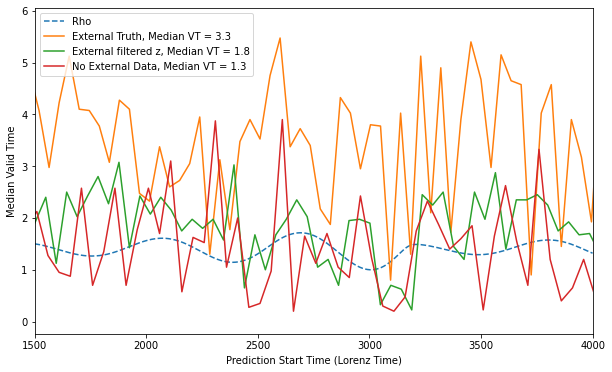

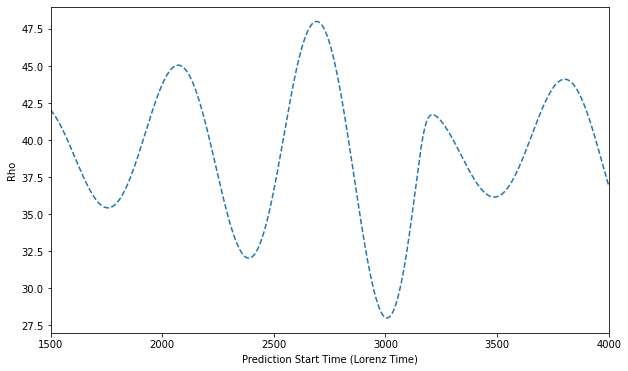

In [3]:
results_file_extern   = 'rossler_external_truth_results.csv'
results_file_noextern = 'rossler_noexternal_results.csv'
results_file_filter   = 'rossler_external_filtered_results.csv'
rho_file     = 'rossler_rho.csv'
step = 0.05
valid_times_extern  = np.loadtxt(results_file_extern, delimiter = ',')*step
valid_times_noextern  = np.loadtxt(results_file_noextern, delimiter = ',')*step
valid_times_filter  = np.loadtxt(results_file_filter, delimiter = ',')*step

rhos         = np.loadtxt(rho_file, delimiter = ',')
median_vt_extern      = np.median(valid_times_extern, axis = 0)
median_vt_noextern    = np.median(valid_times_noextern, axis = 0)
median_vt_filter      = np.median(valid_times_filter, axis = 0)

num_tests    = median_vt_extern.size
init_delay   = 20000
filter_delay = 2564
data_step_noextern = 200000//num_tests
data_step    = (200000-init_delay)//num_tests
init_delay_filt = 10000
data_step_filt = (200000-init_delay_filt-filter_delay)//num_tests
prepred_len  = 3000+200
times = (np.arange(num_tests)*data_step+prepred_len+init_delay)*step
times_filt = (np.arange(num_tests)*data_step_filt+prepred_len+init_delay_filt)*step
times_noextern = (np.arange(num_tests)*data_step_noextern+prepred_len)*step
xbegin = 1500
xend  = 4000

plotrhos = ((rhos-(np.max(rhos)+np.min(rhos))/2)/(np.max(rhos)-np.min(rhos))*(48/28-1)+(1+(48/28-1)/2))

fig = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos, '--',label = 'Rho')
plt.plot(times, median_vt_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(times_filt, median_vt_filter, label = 'External filtered z, Median VT = %0.1f' % np.median(valid_times_filter))
plt.plot(times_noextern, median_vt_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Median Valid Time')
plt.xlim(xbegin,xend)
plt.legend()
plt.savefig('lorenz_rossler_median_vt_wextern.png')
plt.show()

fig2 = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos*28, '--',label = 'Rho')
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Rho')
plt.savefig('rho_values_rossler.png')
plt.xlim(xbegin,xend)
plt.show()

In [4]:
print(np.median(valid_times_filter))
print(np.median(valid_times_noextern))

1.75
1.3


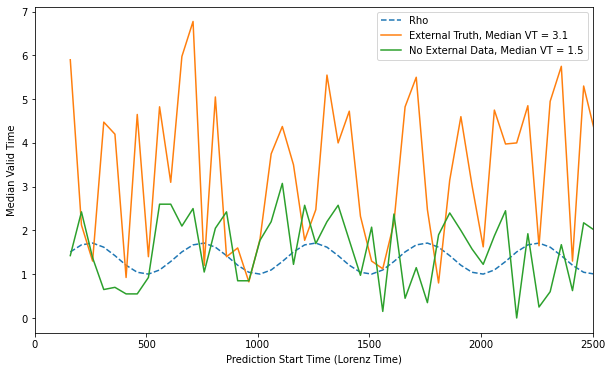

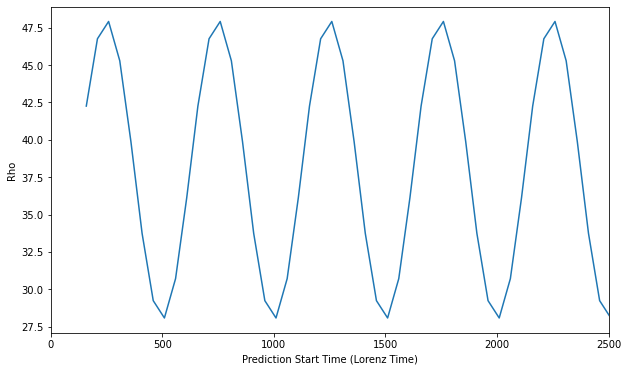

In [8]:
results_file_extern   = 'cosine_external_truth_results.csv'
results_file_noextern = 'cosine_noexternal_results.csv'
# rho_file     = 'cosine_rho.csv'
valid_times_extern  = np.loadtxt(results_file_extern, delimiter = ',')*step
valid_times_noextern  = np.loadtxt(results_file_noextern, delimiter = ',')*step

median_vt_extern      = np.median(valid_times_extern, axis = 0)
median_vt_noextern    = np.median(valid_times_noextern, axis = 0)

num_tests    = median_vt_extern.size
init_delay   = 0
step         = 0.05
data_step    = (200000-init_delay)//num_tests
init_delay_2 = 20000
data_step_2  = (200000-init_delay)//num_tests
prepred_len  = 3000+200
times = (np.arange(num_tests)*data_step+prepred_len+init_delay)*step
times_2 = (np.arange(num_tests)*data_step_2+prepred_len+init_delay)*step
rhos  = r_t_cosine(times)
xend  = 2500

fig = plt.figure(figsize = (10,6))
plt.plot(times, rhos, '--', label = 'Rho')
plt.plot(times_2, median_vt_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(times, median_vt_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Median Valid Time')
plt.xlim(0,xend)
plt.legend()
plt.savefig('lorenz_cosine_median_vt_wextern.png')
plt.show()

fig2 = plt.figure(figsize = (10,6))
plt.plot(times, rhos*28)
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Rho')
plt.xlim(0,xend)
plt.savefig('rho_values_cosine.png')
plt.show()

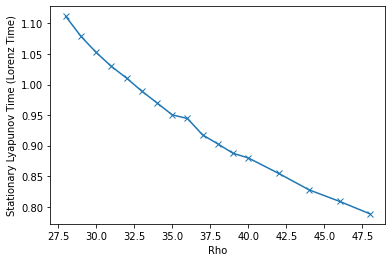

In [9]:
lyapunov_data_1 = np.loadtxt('lorenz_lyapunov_times.csv', delimiter = ',')
lyapunov_data_2 = np.loadtxt('lorenz_lyapunov_times_2.csv', delimiter = ',')
lyapunov_data   = np.vstack((lyapunov_data_1, lyapunov_data_2))

plt.plot(lyapunov_data[:,0], lyapunov_data[:,1], 'x-')
plt.xlabel('Rho')
plt.ylabel('Stationary Lyapunov Time (Lorenz Time)')
plt.savefig('lyapunov_time_vs_rho.png')
plt.show()

In [15]:
results_file_extern   = 'rossler_external_truth_results.csv'
results_file_noextern = 'rossler_noexternal_results.csv'
results_file_filter   = 'rossler_external_filtered_results.csv'
rho_file     = 'rossler_rho.csv'
step = 0.05
valid_times_extern  = np.loadtxt(results_file_extern, delimiter = ',')*step
valid_times_noextern  = np.loadtxt(results_file_noextern, delimiter = ',')*step
valid_times_filter  = np.loadtxt(results_file_filter, delimiter = ',')*step

rhos         = np.loadtxt(rho_file, delimiter = ',')
median_vt_extern      = np.median(valid_times_extern, axis = 0)
median_vt_noextern    = np.median(valid_times_noextern, axis = 0)
median_vt_filter      = np.median(valid_times_filter, axis = 0)

num_tests    = median_vt_extern.size
init_delay   = 20000
filter_delay = 2564
data_step_noextern = 200000//num_tests
data_step    = (200000-init_delay)//num_tests
init_delay_filt = 10000
data_step_filt = (200000-init_delay_filt-filter_delay)//num_tests
prepred_len  = 3000+200
times = (np.arange(num_tests)*data_step+prepred_len+init_delay)*step
times_filt = (np.arange(num_tests)*data_step_filt+prepred_len+init_delay_filt)*step
times_noextern = (np.arange(num_tests)*data_step_noextern+prepred_len)*step
xbegin = 1500
xend  = 4000

plotrhos = ((rhos-(np.max(rhos)+np.min(rhos))/2)/(np.max(rhos)-np.min(rhos))*(48/28-1)+(1+(48/28-1)/2))

lyapunov_interp = interp1d(lyapunov_data[:,0], lyapunov_data[:,1])
rho_interp      = interp1d(np.arange(rhos.size)*step, plotrhos*28)

print(np.max(times))
lyapunov_times_extern = lyapunov_interp(rho_interp(times))
lyapunov_times_filt   = lyapunov_interp(rho_interp(times_filt))
lyapunov_times_noextern = lyapunov_interp(rho_interp(times_noextern))

valid_l_times_extern  = valid_times_extern/lyapunov_times_extern


fig = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos, '--',label = 'Rho')
plt.plot(times, median_vt_extern, label = 'External Truth, Median VT = %0.1f' % np.median(valid_times_extern))
plt.plot(times_filt, median_vt_filter, label = 'External filtered z, Median VT = %0.1f' % np.median(valid_times_filter))
plt.plot(times_noextern, median_vt_noextern, label = 'No External Data, Median VT = %0.1f' % np.median(valid_times_noextern))
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Median Valid Time')
plt.xlim(xbegin,xend)
plt.legend()
plt.savefig('lorenz_rossler_median_vt_wextern.png')
plt.show()

fig2 = plt.figure(figsize = (10,6))
plt.plot(np.arange(rhos.size)*step, plotrhos*28, '--',label = 'Rho')
plt.xlabel('Prediction Start Time (Lorenz Time)')
plt.ylabel('Rho')
plt.savefig('rho_values_rossler.png')
plt.xlim(xbegin,xend)
plt.show()

10115.0


ValueError: A value in x_new is above the interpolation range.